In [1]:
# python
from tqdm.notebook import tqdm
import sys
import os
import importlib
# columnar analysis
import awkward as ak
import mplhep as hep
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import ffschema, sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
import vector
import numpy as np
from scipy import stats
from scipy.stats import expon
from scipy.optimize import differential_evolution

In [2]:
samples_2mu = [
    
    "2Mu2E_100GeV_0p25GeV_0p02mm",
    "2Mu2E_100GeV_0p25GeV_0p2mm",
    "2Mu2E_100GeV_0p25GeV_2mm",
    "2Mu2E_100GeV_0p25GeV_10mm",
    "2Mu2E_100GeV_0p25GeV_20mm",
    
    "2Mu2E_100GeV_1p2GeV_0p096mm",
    "2Mu2E_100GeV_1p2GeV_0p96mm",
    "2Mu2E_100GeV_1p2GeV_9p6mm",
    "2Mu2E_100GeV_1p2GeV_48mm",
    "2Mu2E_100GeV_1p2GeV_96mm",
    
    "2Mu2E_100GeV_5GeV_0p4mm",
    "2Mu2E_100GeV_5GeV_4mm",
    "2Mu2E_100GeV_5GeV_40mm",
    "2Mu2E_100GeV_5GeV_200mm",
    "2Mu2E_100GeV_5GeV_400mm",
    
    "2Mu2E_150GeV_0p25GeV_0p013mm",
    "2Mu2E_150GeV_0p25GeV_0p13mm",
    "2Mu2E_150GeV_0p25GeV_1p3mm",
    "2Mu2E_150GeV_0p25GeV_6p7mm",
    "2Mu2E_150GeV_0p25GeV_13mm",
    
    "2Mu2E_150GeV_1p2GeV_0p064mm",
    "2Mu2E_150GeV_1p2GeV_0p64mm",
    "2Mu2E_150GeV_1p2GeV_6p4mm",
    "2Mu2E_150GeV_1p2GeV_32mm",
    "2Mu2E_150GeV_1p2GeV_64mm",
    
    "2Mu2E_150GeV_5GeV_0p27mm",
    "2Mu2E_150GeV_5GeV_2p7mm",
    "2Mu2E_150GeV_5GeV_27mm",
    "2Mu2E_150GeV_5GeV_130mm",
    "2Mu2E_150GeV_5GeV_270mm",
    
    "2Mu2E_200GeV_0p25GeV_0p01mm",
    "2Mu2E_200GeV_0p25GeV_0p1mm",
    "2Mu2E_200GeV_0p25GeV_1mm",
    "2Mu2E_200GeV_0p25GeV_5mm",
    "2Mu2E_200GeV_0p25GeV_10mm",
    
    "2Mu2E_200GeV_1p2GeV_0p048mm",
    "2Mu2E_200GeV_1p2GeV_0p48mm",
    "2Mu2E_200GeV_1p2GeV_4p8mm",
    "2Mu2E_200GeV_1p2GeV_24mm",
    "2Mu2E_200GeV_1p2GeV_48mm",
    
    "2Mu2E_200GeV_5GeV_0p2mm",
    "2Mu2E_200GeV_5GeV_2mm",
    "2Mu2E_200GeV_5GeV_20mm",
    "2Mu2E_200GeV_5GeV_100mm",
    "2Mu2E_200GeV_5GeV_200mm",
    
    "2Mu2E_500GeV_0p25GeV_0p004mm",
    "2Mu2E_500GeV_0p25GeV_0p04mm",
    "2Mu2E_500GeV_0p25GeV_0p4mm",
    "2Mu2E_500GeV_0p25GeV_2mm",
    "2Mu2E_500GeV_0p25GeV_4mm",
    
    "2Mu2E_500GeV_1p2GeV_0p019mm",
    "2Mu2E_500GeV_1p2GeV_0p19mm",
    "2Mu2E_500GeV_1p2GeV_1p9mm",
    "2Mu2E_500GeV_1p2GeV_9p6mm",
    "2Mu2E_500GeV_1p2GeV_19mm",
    
    "2Mu2E_500GeV_5GeV_0p08mm",
    "2Mu2E_500GeV_5GeV_0p8mm",
    "2Mu2E_500GeV_5GeV_8mm",
    "2Mu2E_500GeV_5GeV_40mm",
    "2Mu2E_500GeV_5GeV_80mm",
    
    "2Mu2E_800GeV_0p25GeV_0p0025mm",
    "2Mu2E_800GeV_0p25GeV_0p025mm",
    "2Mu2E_800GeV_0p25GeV_0p25mm",
    "2Mu2E_800GeV_0p25GeV_1p2mm",
    "2Mu2E_800GeV_0p25GeV_2p5mm",
    
    "2Mu2E_800GeV_1p2GeV_0p012mm",
    "2Mu2E_800GeV_1p2GeV_0p12mm",
    "2Mu2E_800GeV_1p2GeV_1p2mm",
    "2Mu2E_800GeV_1p2GeV_6mm",
    "2Mu2E_800GeV_1p2GeV_12mm",
    
    "2Mu2E_800GeV_5GeV_0p05mm",
    "2Mu2E_800GeV_5GeV_0p5mm",
    "2Mu2E_800GeV_5GeV_5mm",
    "2Mu2E_800GeV_5GeV_25mm",
    "2Mu2E_800GeV_5GeV_50mm",
    
    "2Mu2E_1000GeV_0p25GeV_0p002mm",
    "2Mu2E_1000GeV_0p25GeV_0p02mm",
    "2Mu2E_1000GeV_0p25GeV_0p2mm",
    "2Mu2E_1000GeV_0p25GeV_1mm",
    "2Mu2E_1000GeV_0p25GeV_2mm",
    
    "2Mu2E_1000GeV_1p2GeV_0p0096mm",
    "2Mu2E_1000GeV_1p2GeV_0p096mm",
    "2Mu2E_1000GeV_1p2GeV_0p96mm",
    "2Mu2E_1000GeV_1p2GeV_4p8mm",
    "2Mu2E_1000GeV_1p2GeV_9p6mm",
    
    "2Mu2E_1000GeV_5GeV_0p04mm",
    "2Mu2E_1000GeV_5GeV_0p4mm",
    "2Mu2E_1000GeV_5GeV_4mm",
    "2Mu2E_1000GeV_5GeV_20mm",
    "2Mu2E_1000GeV_5GeV_40mm",
    
]

In [3]:
samples_4mu = [
    
    "4Mu_100GeV_0p25GeV_0p02mm",
    "4Mu_100GeV_0p25GeV_0p2mm",
    "4Mu_100GeV_0p25GeV_2mm",
    "4Mu_100GeV_0p25GeV_10mm",
    "4Mu_100GeV_0p25GeV_20mm",
    
    "4Mu_100GeV_1p2GeV_0p096mm",
    "4Mu_100GeV_1p2GeV_0p96mm",
    "4Mu_100GeV_1p2GeV_9p6mm",
    "4Mu_100GeV_1p2GeV_48mm",
    "4Mu_100GeV_1p2GeV_96mm",
    
    "4Mu_100GeV_5GeV_0p4mm",
    "4Mu_100GeV_5GeV_4mm",
    "4Mu_100GeV_5GeV_40mm",
    "4Mu_100GeV_5GeV_200mm",
    "4Mu_100GeV_5GeV_400mm",
    
    "4Mu_150GeV_0p25GeV_0p013mm",
    "4Mu_150GeV_0p25GeV_0p13mm",
    "4Mu_150GeV_0p25GeV_1p3mm",
    "4Mu_150GeV_0p25GeV_6p7mm",
    "4Mu_150GeV_0p25GeV_13mm",
    
    "4Mu_150GeV_1p2GeV_0p064mm",
    "4Mu_150GeV_1p2GeV_0p64mm",
    "4Mu_150GeV_1p2GeV_6p4mm",
    "4Mu_150GeV_1p2GeV_32mm",
    "4Mu_150GeV_1p2GeV_64mm",
    
    "4Mu_150GeV_5GeV_0p27mm",
    "4Mu_150GeV_5GeV_2p7mm",
    "4Mu_150GeV_5GeV_27mm",
    "4Mu_150GeV_5GeV_130mm",
    "4Mu_150GeV_5GeV_270mm",
    
    "4Mu_200GeV_0p25GeV_0p01mm",
    "4Mu_200GeV_0p25GeV_0p1mm",
    "4Mu_200GeV_0p25GeV_1mm",
    "4Mu_200GeV_0p25GeV_5mm",
    "4Mu_200GeV_0p25GeV_10mm",
    
    "4Mu_200GeV_1p2GeV_0p048mm",
    "4Mu_200GeV_1p2GeV_0p48mm",
    "4Mu_200GeV_1p2GeV_4p8mm",
    "4Mu_200GeV_1p2GeV_24mm",
    "4Mu_200GeV_1p2GeV_48mm",
    
    "4Mu_200GeV_5GeV_0p2mm",
    "4Mu_200GeV_5GeV_2mm",
    "4Mu_200GeV_5GeV_20mm",
    "4Mu_200GeV_5GeV_100mm",
    "4Mu_200GeV_5GeV_200mm",
    
    "4Mu_500GeV_0p25GeV_0p004mm",
    "4Mu_500GeV_0p25GeV_0p04mm",
    "4Mu_500GeV_0p25GeV_0p4mm",
    "4Mu_500GeV_0p25GeV_2mm",
    "4Mu_500GeV_0p25GeV_4mm",
    
    "4Mu_500GeV_1p2GeV_0p019mm",
    "4Mu_500GeV_1p2GeV_0p19mm",
    "4Mu_500GeV_1p2GeV_1p9mm",
    "4Mu_500GeV_1p2GeV_9p6mm",
    "4Mu_500GeV_1p2GeV_19mm",
    
    "4Mu_500GeV_5GeV_0p08mm",
    "4Mu_500GeV_5GeV_0p8mm",
    "4Mu_500GeV_5GeV_8mm",
    "4Mu_500GeV_5GeV_40mm",
    "4Mu_500GeV_5GeV_80mm",
    
    "4Mu_800GeV_0p25GeV_0p0025mm",
    "4Mu_800GeV_0p25GeV_0p025mm",
    "4Mu_800GeV_0p25GeV_0p25mm",
    "4Mu_800GeV_0p25GeV_1p2mm",
    "4Mu_800GeV_0p25GeV_2p5mm",
    
    "4Mu_800GeV_1p2GeV_0p012mm",
    "4Mu_800GeV_1p2GeV_0p12mm",
    "4Mu_800GeV_1p2GeV_1p2mm",
    "4Mu_800GeV_1p2GeV_6mm",
    "4Mu_800GeV_1p2GeV_12mm",
    
    "4Mu_800GeV_5GeV_0p05mm",
    "4Mu_800GeV_5GeV_0p5mm",
    "4Mu_800GeV_5GeV_5mm",
    "4Mu_800GeV_5GeV_25mm",
    "4Mu_800GeV_5GeV_50mm",
    
    "4Mu_1000GeV_0p25GeV_0p002mm",
    "4Mu_1000GeV_0p25GeV_0p02mm",
    "4Mu_1000GeV_0p25GeV_0p2mm",
    "4Mu_1000GeV_0p25GeV_1mm",
    "4Mu_1000GeV_0p25GeV_2mm",
    
    "4Mu_1000GeV_1p2GeV_0p0096mm",
    "4Mu_1000GeV_1p2GeV_0p096mm",
    "4Mu_1000GeV_1p2GeV_0p96mm",
    "4Mu_1000GeV_1p2GeV_4p8mm",
    "4Mu_1000GeV_1p2GeV_9p6mm",
    
    "4Mu_1000GeV_5GeV_0p04mm",
    "4Mu_1000GeV_5GeV_0p4mm",
    "4Mu_1000GeV_5GeV_4mm",
    "4Mu_1000GeV_5GeV_20mm",
    "4Mu_1000GeV_5GeV_40mm",
    
]

In [3]:
fileset_2mu = utilities.make_fileset(samples_2mu, "ffntuple_v4")

events_2mu = {}

for i in tqdm(samples_2mu):
    fname = fileset_2mu[i][0]
    print(fname)
    events_2mu[i] = NanoEventsFactory.from_root(
        fname,
        treepath='ffNtuplizer/ffNtuple',
        schemaclass=ffschema.FFSchema,
    ).events()

  0%|          | 0/90 [00:00<?, ?it/s]

root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/SIDM_XXTo2ATo2Mu2E_mXX-100_mA-0p25_ctau-0p02_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1/210326_153435/0000/ffNtuple_1.root
root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/SIDM_XXTo2ATo2Mu2E_mXX-100_mA-0p25_ctau-0p2_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1/210326_161009/0000/ffNtuple_1.root
root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/SIDM_XXTo2ATo2Mu2E_mXX-100_mA-0p25_ctau-2_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1/210326_154556/0000/ffNtuple_1.root
root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/SIDM_XXTo2ATo2Mu2E_mXX-100_mA-0p25_ctau-10_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1/210326_152735/0000/ffNtuple_1.root
root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/SIDM_XXTo2ATo2Mu2E_mXX-100_mA-0p25_ctau-20_TuneCP5_13TeV-m

In [ ]:
fileset_4mu = utilities.make_fileset(samples_4mu, "ffntuple_v2")

events_4mu = {}

for i in tqdm(samples_4mu):
    fname = fileset_4mu[i][0]
    print(fname)
    events_4mu[i] = NanoEventsFactory.from_root(
        fname,
        treepath='ffNtuplizer/ffNtuple',
        schemaclass=ffschema.FFSchema,
    ).events()

  0%|          | 0/90 [00:00<?, ?it/s]

root://xcache//store/group/lpcmetx/SIDM/ffNtupleV2/2018/SIDM_XXTo2ATo4Mu_mXX-100_mA-0p25_ctau-0p02_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1/200321_043749/0000/ffNtuple_1.root


In [4]:
def extract_values(events, sample):
    
    masked_gen = events["{0}".format(sample)].gen[(abs(events["{0}".format(sample)].gen.pid) == 32) & (abs(events["{0}".format(sample)].gen.daupid) == 13)]
    
    masked_gen_vec = vector.zip({
        "px": masked_gen.x,
        "py": masked_gen.y,
        "pz": masked_gen.z,
        "e": masked_gen.t})
    
    masked_gen_vec_x = masked_gen_vec.x
    masked_gen_vec_y = masked_gen_vec.y
    masked_gen_vec_z = masked_gen_vec.z
    masked_gen_vec_t = masked_gen_vec.t
    
    rho = ak.flatten((masked_gen.dauvtx - masked_gen.vtx).rho)
    gamma = ak.flatten(masked_gen_vec.gamma)
    beta = ak.flatten(masked_gen_vec.beta)
    
    return rho, gamma, beta

In [5]:
def plotting_2mu2e(events, sample, ranges, i, j, co):
    
    plt_range = (0, ranges)
    
    rho, gamma, beta = extract_values(events, sample)
    
    lxyz_gb = rho/(gamma * beta)
    P = stats.expon.fit(lxyz_gb)
    
    ax[i][j].hist(lxyz_gb, range=plt_range, linewidth=3, bins=100, histtype='step', label=sample+"_V4", density=True, color=co)
    ax[i][j].plot(np.linspace(*plt_range,100), stats.expon.pdf(np.linspace(*plt_range,100), *P), label=fr"exp[ -(x - {P[0]:.3e}) / {P[1]:.3e} ] / {P[1]:.3e}", color='black')
    ax[i][j].set_yscale("log")
    ax[i][j].legend(fontsize=18)
    ax[i][j].set_xlabel(r"$L_{xyz}$/$\beta\gamma$")

In [ ]:
def plotting_4mu(events, sample, ranges, i, j, co):
    
    plt_range = (0, ranges)
    
    rho, gamma, beta = extract_values(events, sample)
    
    lxyz_gb = rho/(gamma * beta)
    P = stats.expon.fit(lxyz_gb)
    
    ax[i][j].hist(lxyz_gb, range=plt_range, linewidth=3, bins=100, histtype='step', label=sample+"_V2", density=True, color=co)
    ax[i][j].plot(np.linspace(*plt_range,100), stats.expon.pdf(np.linspace(*plt_range,100), *P), label=fr"exp[ -(x - {P[0]:.3e}) / {P[1]:.3e} ] / {P[1]:.3e}", color='black')
    ax[i][j].set_yscale("log")
    ax[i][j].legend(fontsize=18)
    ax[i][j].set_xlabel(r"$L_{xyz}$/$\beta\gamma$")

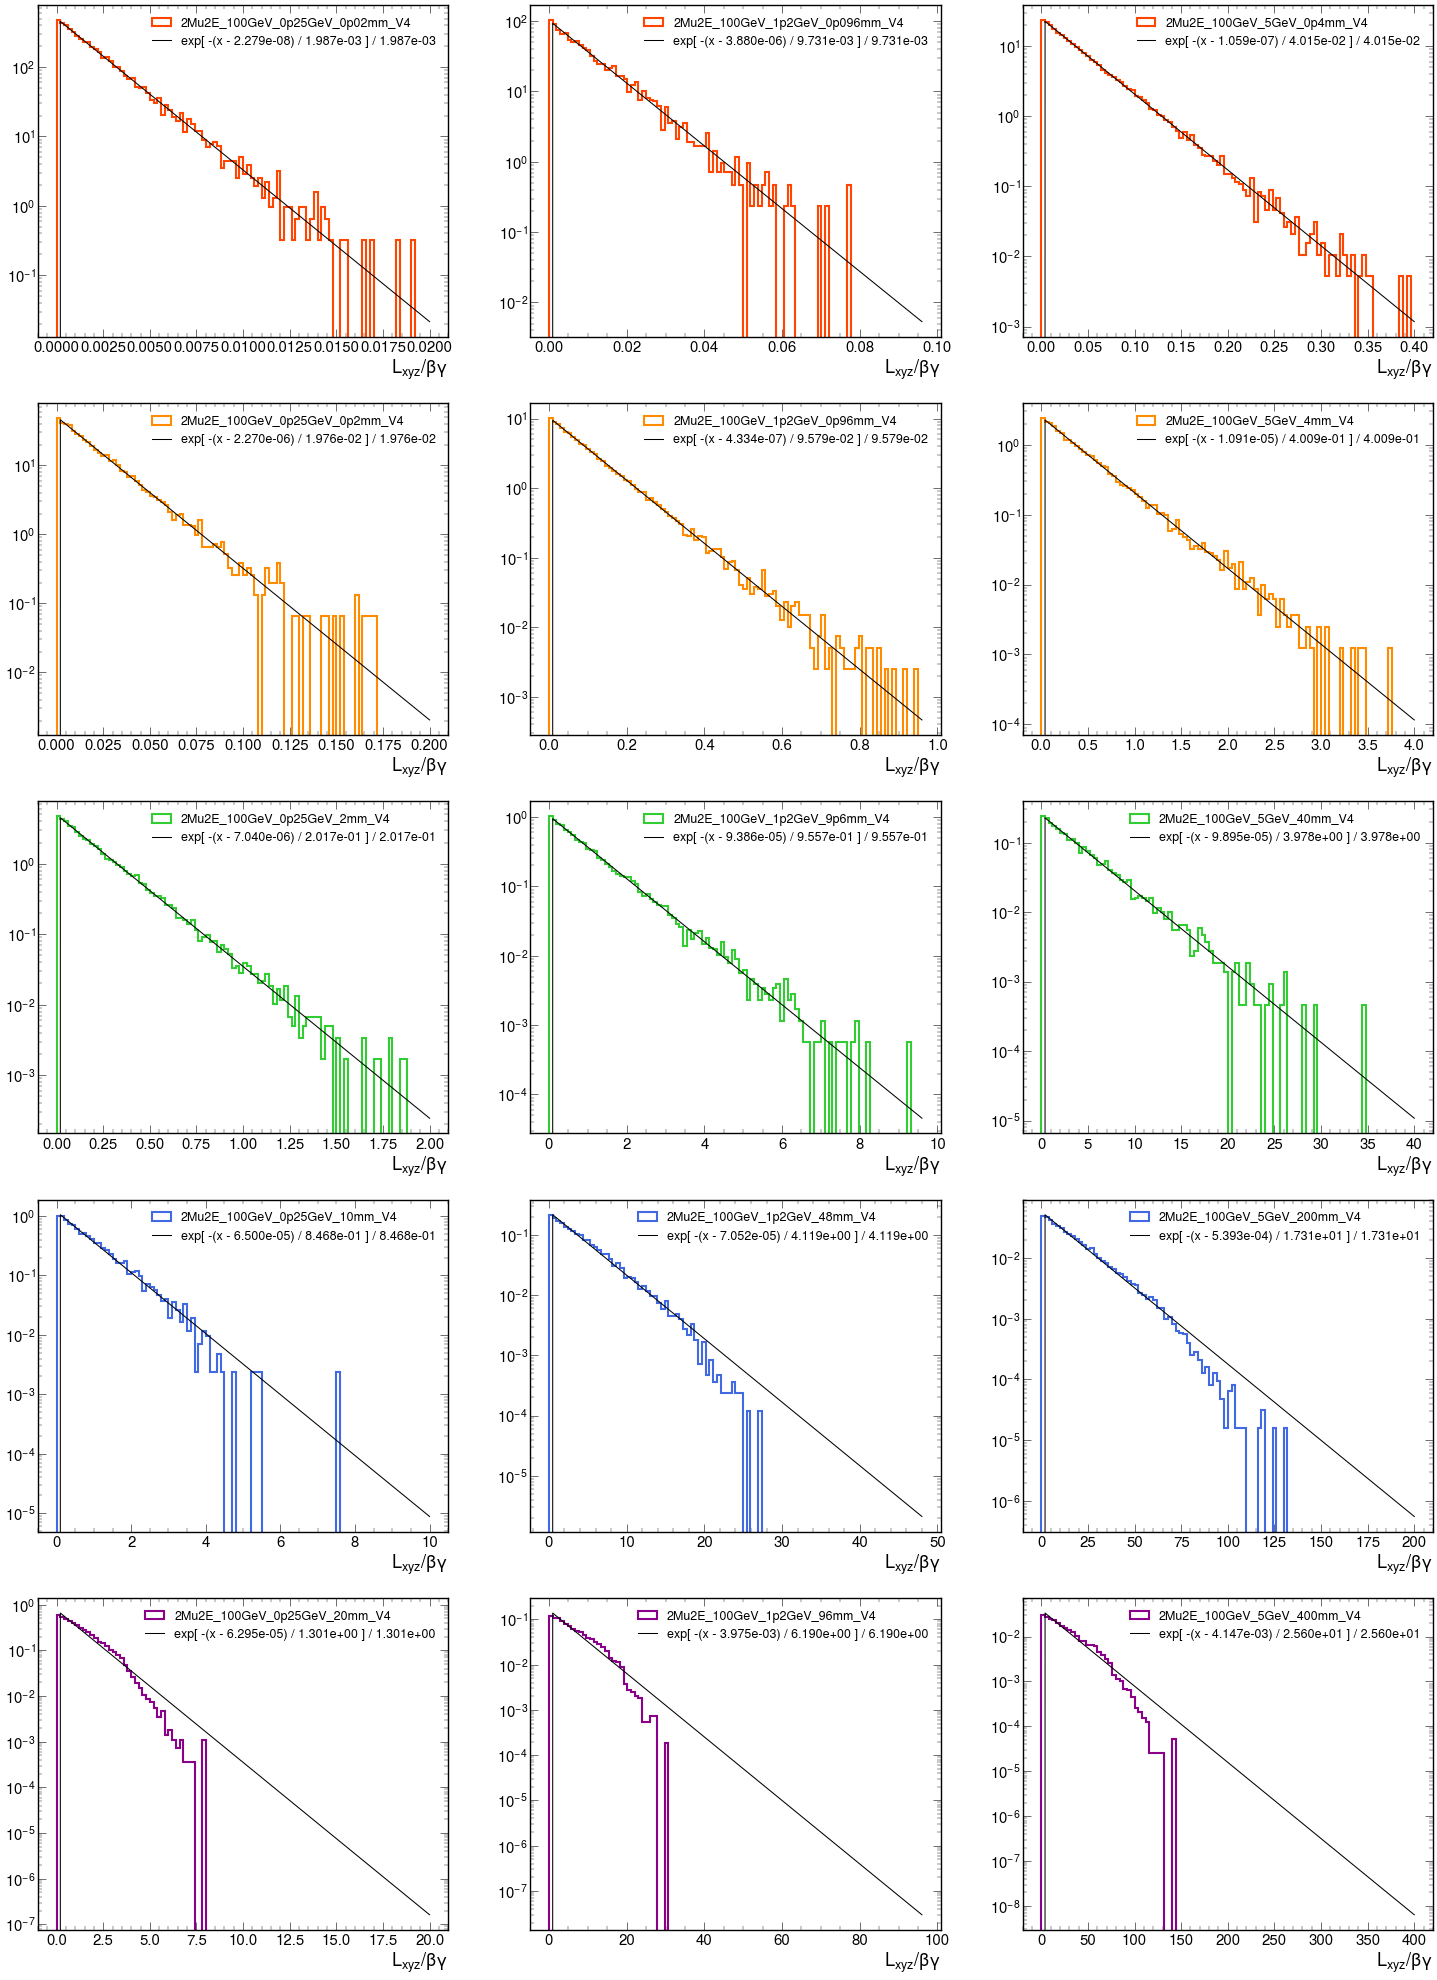

In [7]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(5, 3, figsize=(36, 50)) 

plotting_2mu2e(events_2mu, "2Mu2E_100GeV_0p25GeV_0p02mm", 0.02,0,0, "orangered")
plotting_2mu2e(events_2mu, "2Mu2E_100GeV_1p2GeV_0p096mm", 0.096,0,1, "orangered")
plotting_2mu2e(events_2mu, "2Mu2E_100GeV_5GeV_0p4mm", 0.4,0,2, "orangered")

plotting_2mu2e(events_2mu, "2Mu2E_100GeV_0p25GeV_0p2mm", 0.2,1,0, "darkorange")
plotting_2mu2e(events_2mu, "2Mu2E_100GeV_1p2GeV_0p96mm", 0.96,1,1, "darkorange")
plotting_2mu2e(events_2mu, "2Mu2E_100GeV_5GeV_4mm", 4,1,2, "darkorange")

plotting_2mu2e(events_2mu, "2Mu2E_100GeV_0p25GeV_2mm", 2,2,0, "limegreen")
plotting_2mu2e(events_2mu, "2Mu2E_100GeV_1p2GeV_9p6mm", 9.6,2,1, "limegreen")
plotting_2mu2e(events_2mu, "2Mu2E_100GeV_5GeV_40mm", 40,2,2, "limegreen")

plotting_2mu2e(events_2mu, "2Mu2E_100GeV_0p25GeV_10mm", 10,3,0, "royalblue")
plotting_2mu2e(events_2mu, "2Mu2E_100GeV_1p2GeV_48mm", 48,3,1, "royalblue")
plotting_2mu2e(events_2mu, "2Mu2E_100GeV_5GeV_200mm", 200,3,2, "royalblue")

plotting_2mu2e(events_2mu, "2Mu2E_100GeV_0p25GeV_20mm", 20,4,0, "darkmagenta")
plotting_2mu2e(events_2mu, "2Mu2E_100GeV_1p2GeV_96mm", 96,4,1, "darkmagenta")
plotting_2mu2e(events_2mu, "2Mu2E_100GeV_5GeV_400mm", 400,4,2, "darkmagenta")

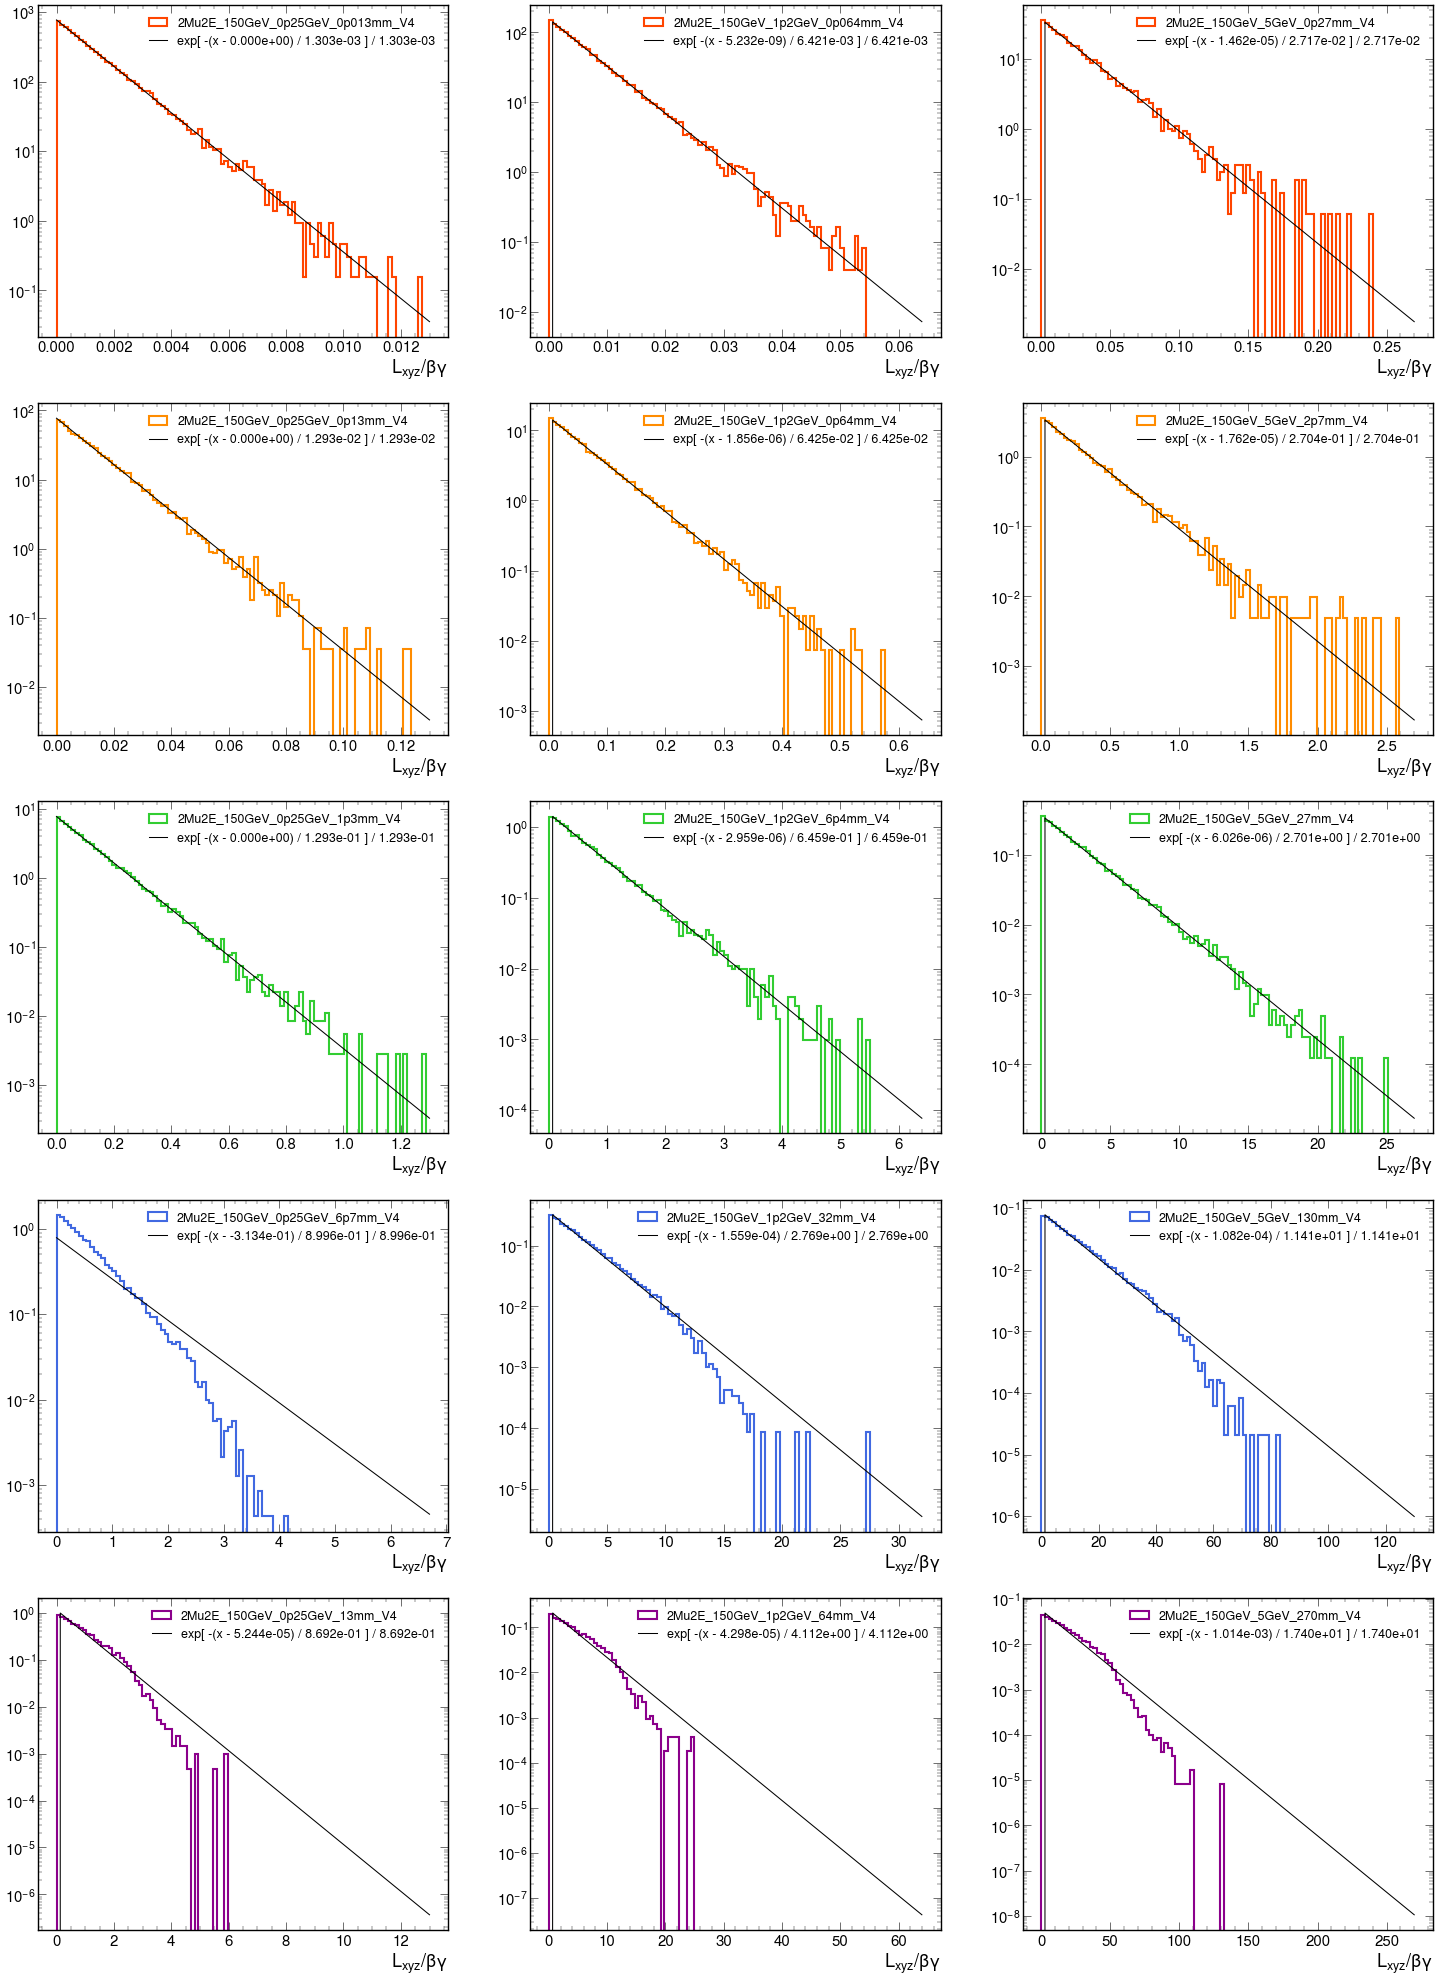

In [9]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(5, 3, figsize=(36, 50)) 

plotting_2mu2e(events_2mu, "2Mu2E_150GeV_0p25GeV_0p013mm", 0.013,0,0, "orangered")
plotting_2mu2e(events_2mu, "2Mu2E_150GeV_1p2GeV_0p064mm", 0.064,0,1, "orangered")
plotting_2mu2e(events_2mu, "2Mu2E_150GeV_5GeV_0p27mm", 0.27,0,2, "orangered")

plotting_2mu2e(events_2mu, "2Mu2E_150GeV_0p25GeV_0p13mm", 0.13,1,0, "darkorange")
plotting_2mu2e(events_2mu, "2Mu2E_150GeV_1p2GeV_0p64mm", 0.64,1,1, "darkorange")
plotting_2mu2e(events_2mu, "2Mu2E_150GeV_5GeV_2p7mm", 2.7,1,2, "darkorange")

plotting_2mu2e(events_2mu, "2Mu2E_150GeV_0p25GeV_1p3mm", 1.3,2,0, "limegreen")
plotting_2mu2e(events_2mu, "2Mu2E_150GeV_1p2GeV_6p4mm", 6.4,2,1, "limegreen")
plotting_2mu2e(events_2mu, "2Mu2E_150GeV_5GeV_27mm", 27,2,2, "limegreen")

plotting_2mu2e(events_2mu, "2Mu2E_150GeV_0p25GeV_6p7mm", 6.7,3,0, "royalblue")
plotting_2mu2e(events_2mu, "2Mu2E_150GeV_1p2GeV_32mm", 32,3,1, "royalblue")
plotting_2mu2e(events_2mu, "2Mu2E_150GeV_5GeV_130mm", 130,3,2, "royalblue")

plotting_2mu2e(events_2mu, "2Mu2E_150GeV_0p25GeV_13mm", 13,4,0, "darkmagenta")
plotting_2mu2e(events_2mu, "2Mu2E_150GeV_1p2GeV_64mm", 64,4,1, "darkmagenta")
plotting_2mu2e(events_2mu, "2Mu2E_150GeV_5GeV_270mm", 270,4,2, "darkmagenta")

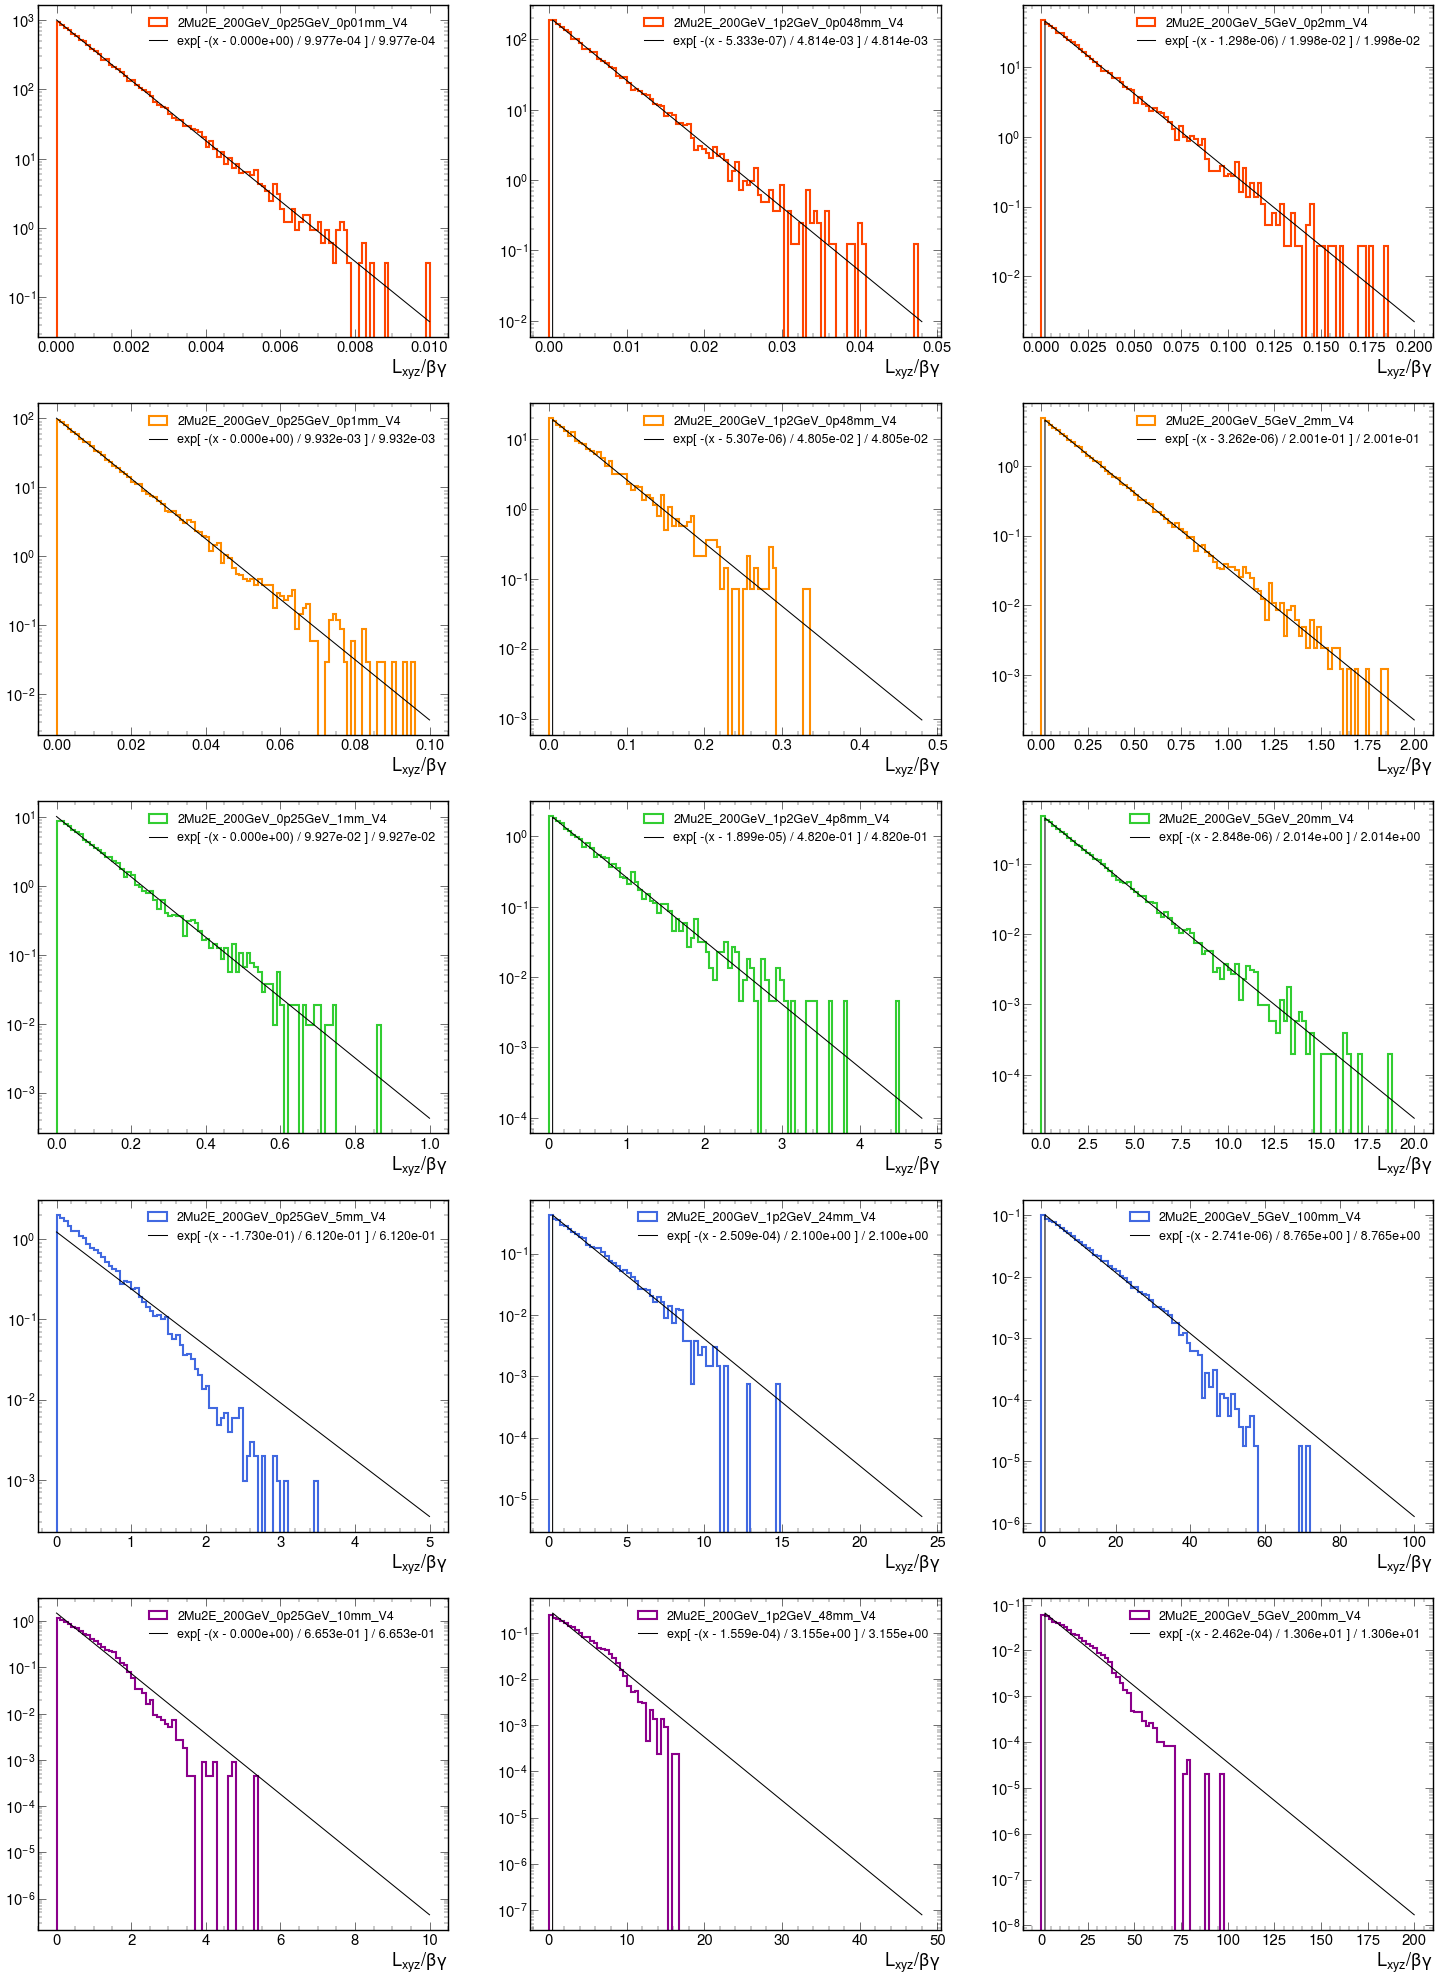

In [10]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(5, 3, figsize=(36, 50)) 

plotting_2mu2e(events_2mu, "2Mu2E_200GeV_0p25GeV_0p01mm", 0.01,0,0, "orangered")
plotting_2mu2e(events_2mu, "2Mu2E_200GeV_1p2GeV_0p048mm", 0.048,0,1, "orangered")
plotting_2mu2e(events_2mu, "2Mu2E_200GeV_5GeV_0p2mm", 0.2,0,2, "orangered")

plotting_2mu2e(events_2mu, "2Mu2E_200GeV_0p25GeV_0p1mm", 0.1,1,0, "darkorange")
plotting_2mu2e(events_2mu, "2Mu2E_200GeV_1p2GeV_0p48mm", 0.48,1,1, "darkorange")
plotting_2mu2e(events_2mu, "2Mu2E_200GeV_5GeV_2mm", 2,1,2, "darkorange")

plotting_2mu2e(events_2mu, "2Mu2E_200GeV_0p25GeV_1mm", 1,2,0, "limegreen")
plotting_2mu2e(events_2mu, "2Mu2E_200GeV_1p2GeV_4p8mm", 4.8,2,1, "limegreen")
plotting_2mu2e(events_2mu, "2Mu2E_200GeV_5GeV_20mm", 20,2,2, "limegreen")

plotting_2mu2e(events_2mu, "2Mu2E_200GeV_0p25GeV_5mm", 5,3,0, "royalblue")
plotting_2mu2e(events_2mu, "2Mu2E_200GeV_1p2GeV_24mm", 24,3,1, "royalblue")
plotting_2mu2e(events_2mu, "2Mu2E_200GeV_5GeV_100mm", 100,3,2, "royalblue")

plotting_2mu2e(events_2mu, "2Mu2E_200GeV_0p25GeV_10mm", 10,4,0, "darkmagenta")
plotting_2mu2e(events_2mu, "2Mu2E_200GeV_1p2GeV_48mm", 48,4,1, "darkmagenta")
plotting_2mu2e(events_2mu, "2Mu2E_200GeV_5GeV_200mm", 200,4,2, "darkmagenta")

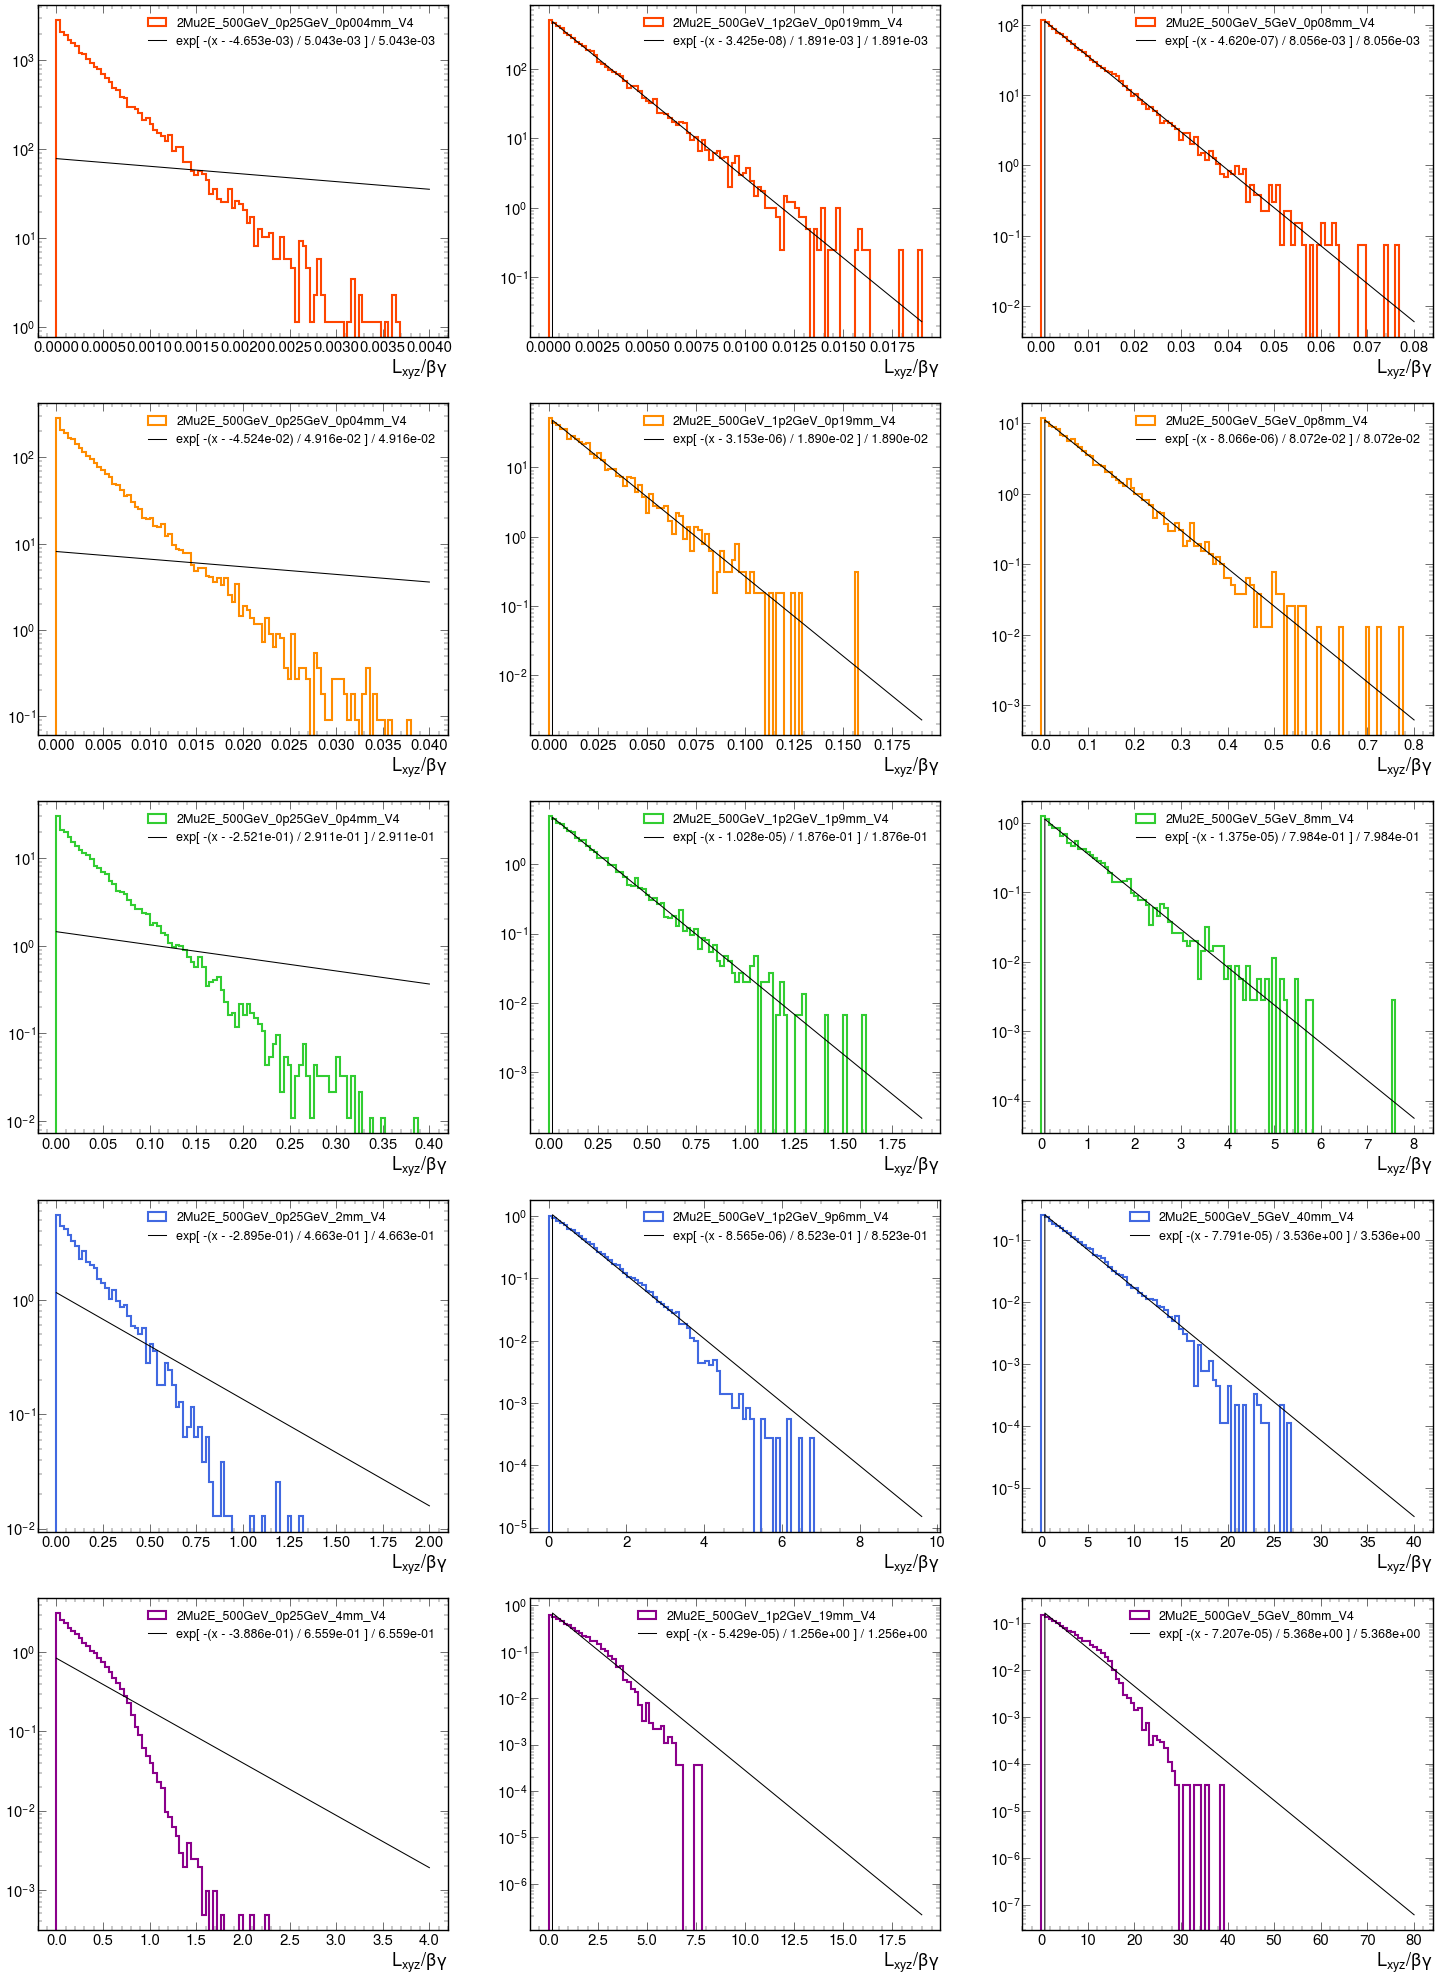

In [6]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(5, 3, figsize=(36, 50)) 

plotting_2mu2e(events_2mu, "2Mu2E_500GeV_0p25GeV_0p004mm", 0.004,0,0, "orangered")
plotting_2mu2e(events_2mu, "2Mu2E_500GeV_1p2GeV_0p019mm", 0.019,0,1, "orangered")
plotting_2mu2e(events_2mu, "2Mu2E_500GeV_5GeV_0p08mm", 0.08,0,2, "orangered")

plotting_2mu2e(events_2mu, "2Mu2E_500GeV_0p25GeV_0p04mm", 0.04,1,0, "darkorange")
plotting_2mu2e(events_2mu, "2Mu2E_500GeV_1p2GeV_0p19mm", 0.19,1,1, "darkorange")
plotting_2mu2e(events_2mu, "2Mu2E_500GeV_5GeV_0p8mm", 0.8,1,2, "darkorange")

plotting_2mu2e(events_2mu, "2Mu2E_500GeV_0p25GeV_0p4mm", 0.4,2,0, "limegreen")
plotting_2mu2e(events_2mu, "2Mu2E_500GeV_1p2GeV_1p9mm", 1.9,2,1, "limegreen")
plotting_2mu2e(events_2mu, "2Mu2E_500GeV_5GeV_8mm", 8,2,2, "limegreen")

plotting_2mu2e(events_2mu, "2Mu2E_500GeV_0p25GeV_2mm", 2,3,0, "royalblue")
plotting_2mu2e(events_2mu, "2Mu2E_500GeV_1p2GeV_9p6mm", 9.6,3,1, "royalblue")
plotting_2mu2e(events_2mu, "2Mu2E_500GeV_5GeV_40mm", 40,3,2, "royalblue")

plotting_2mu2e(events_2mu, "2Mu2E_500GeV_0p25GeV_4mm", 4,4,0, "darkmagenta")
plotting_2mu2e(events_2mu, "2Mu2E_500GeV_1p2GeV_19mm", 19,4,1, "darkmagenta")
plotting_2mu2e(events_2mu, "2Mu2E_500GeV_5GeV_80mm", 80,4,2, "darkmagenta")

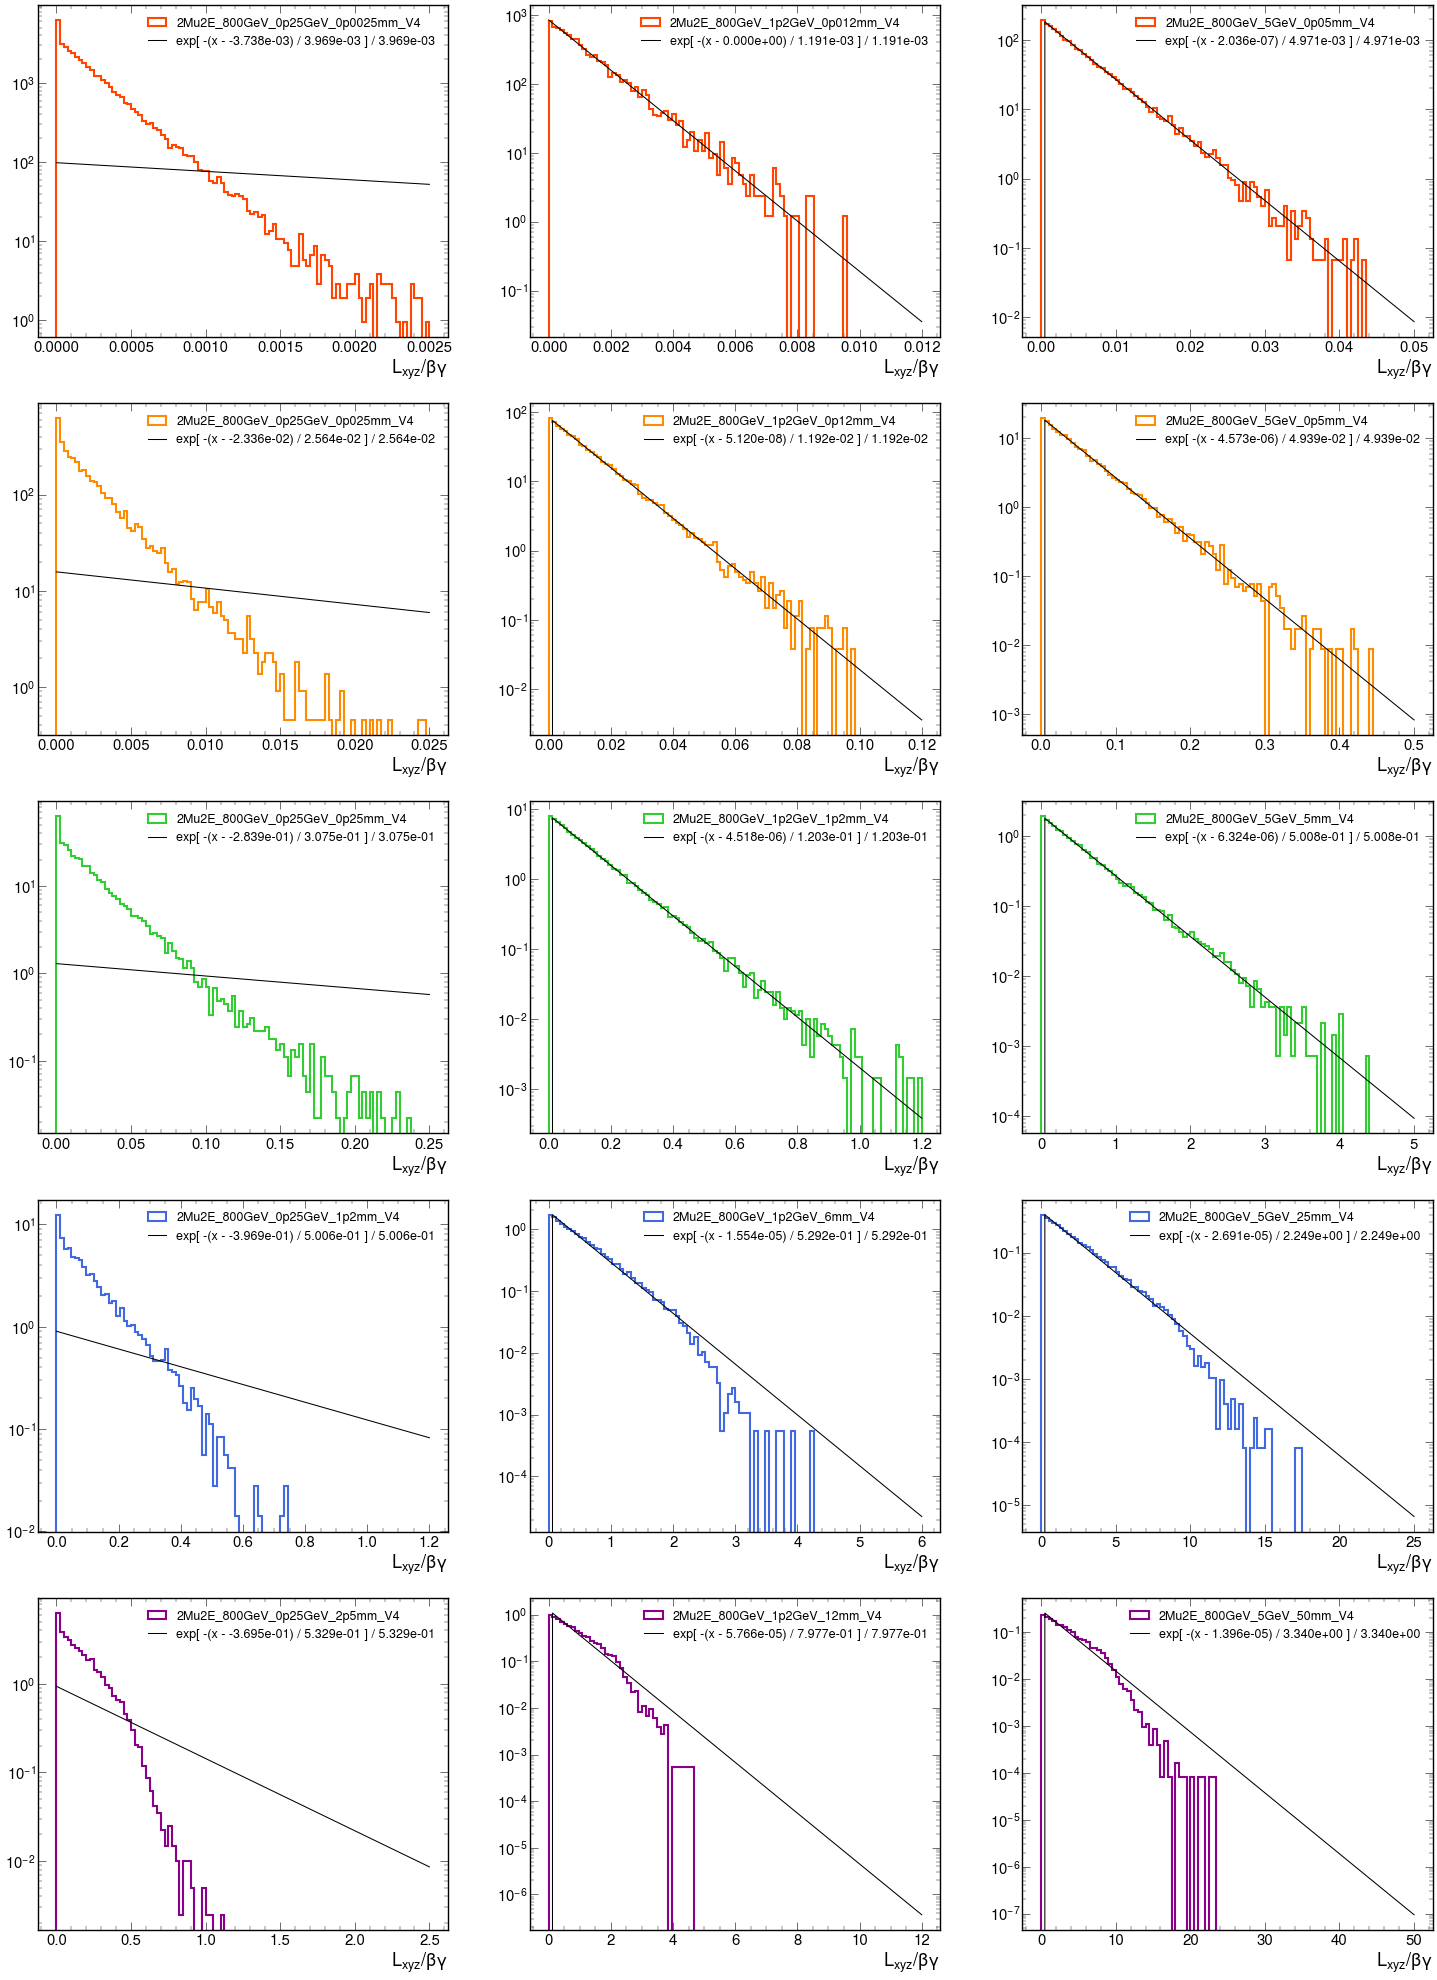

In [7]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(5, 3, figsize=(36, 50)) 

plotting_2mu2e(events_2mu, "2Mu2E_800GeV_0p25GeV_0p0025mm", 0.0025,0,0, "orangered")
plotting_2mu2e(events_2mu, "2Mu2E_800GeV_1p2GeV_0p012mm", 0.012,0,1, "orangered")
plotting_2mu2e(events_2mu, "2Mu2E_800GeV_5GeV_0p05mm", 0.05,0,2, "orangered")

plotting_2mu2e(events_2mu, "2Mu2E_800GeV_0p25GeV_0p025mm", 0.025,1,0, "darkorange")
plotting_2mu2e(events_2mu, "2Mu2E_800GeV_1p2GeV_0p12mm", 0.12,1,1, "darkorange")
plotting_2mu2e(events_2mu, "2Mu2E_800GeV_5GeV_0p5mm", 0.5,1,2, "darkorange")

plotting_2mu2e(events_2mu, "2Mu2E_800GeV_0p25GeV_0p25mm", 0.25,2,0, "limegreen")
plotting_2mu2e(events_2mu, "2Mu2E_800GeV_1p2GeV_1p2mm", 1.2,2,1, "limegreen")
plotting_2mu2e(events_2mu, "2Mu2E_800GeV_5GeV_5mm", 5,2,2, "limegreen")

plotting_2mu2e(events_2mu, "2Mu2E_800GeV_0p25GeV_1p2mm", 1.2,3,0, "royalblue")
plotting_2mu2e(events_2mu, "2Mu2E_800GeV_1p2GeV_6mm", 6,3,1, "royalblue")
plotting_2mu2e(events_2mu, "2Mu2E_800GeV_5GeV_25mm", 25,3,2, "royalblue")

plotting_2mu2e(events_2mu, "2Mu2E_800GeV_0p25GeV_2p5mm", 2.5,4,0, "darkmagenta")
plotting_2mu2e(events_2mu, "2Mu2E_800GeV_1p2GeV_12mm", 12,4,1, "darkmagenta")
plotting_2mu2e(events_2mu, "2Mu2E_800GeV_5GeV_50mm", 50,4,2, "darkmagenta")

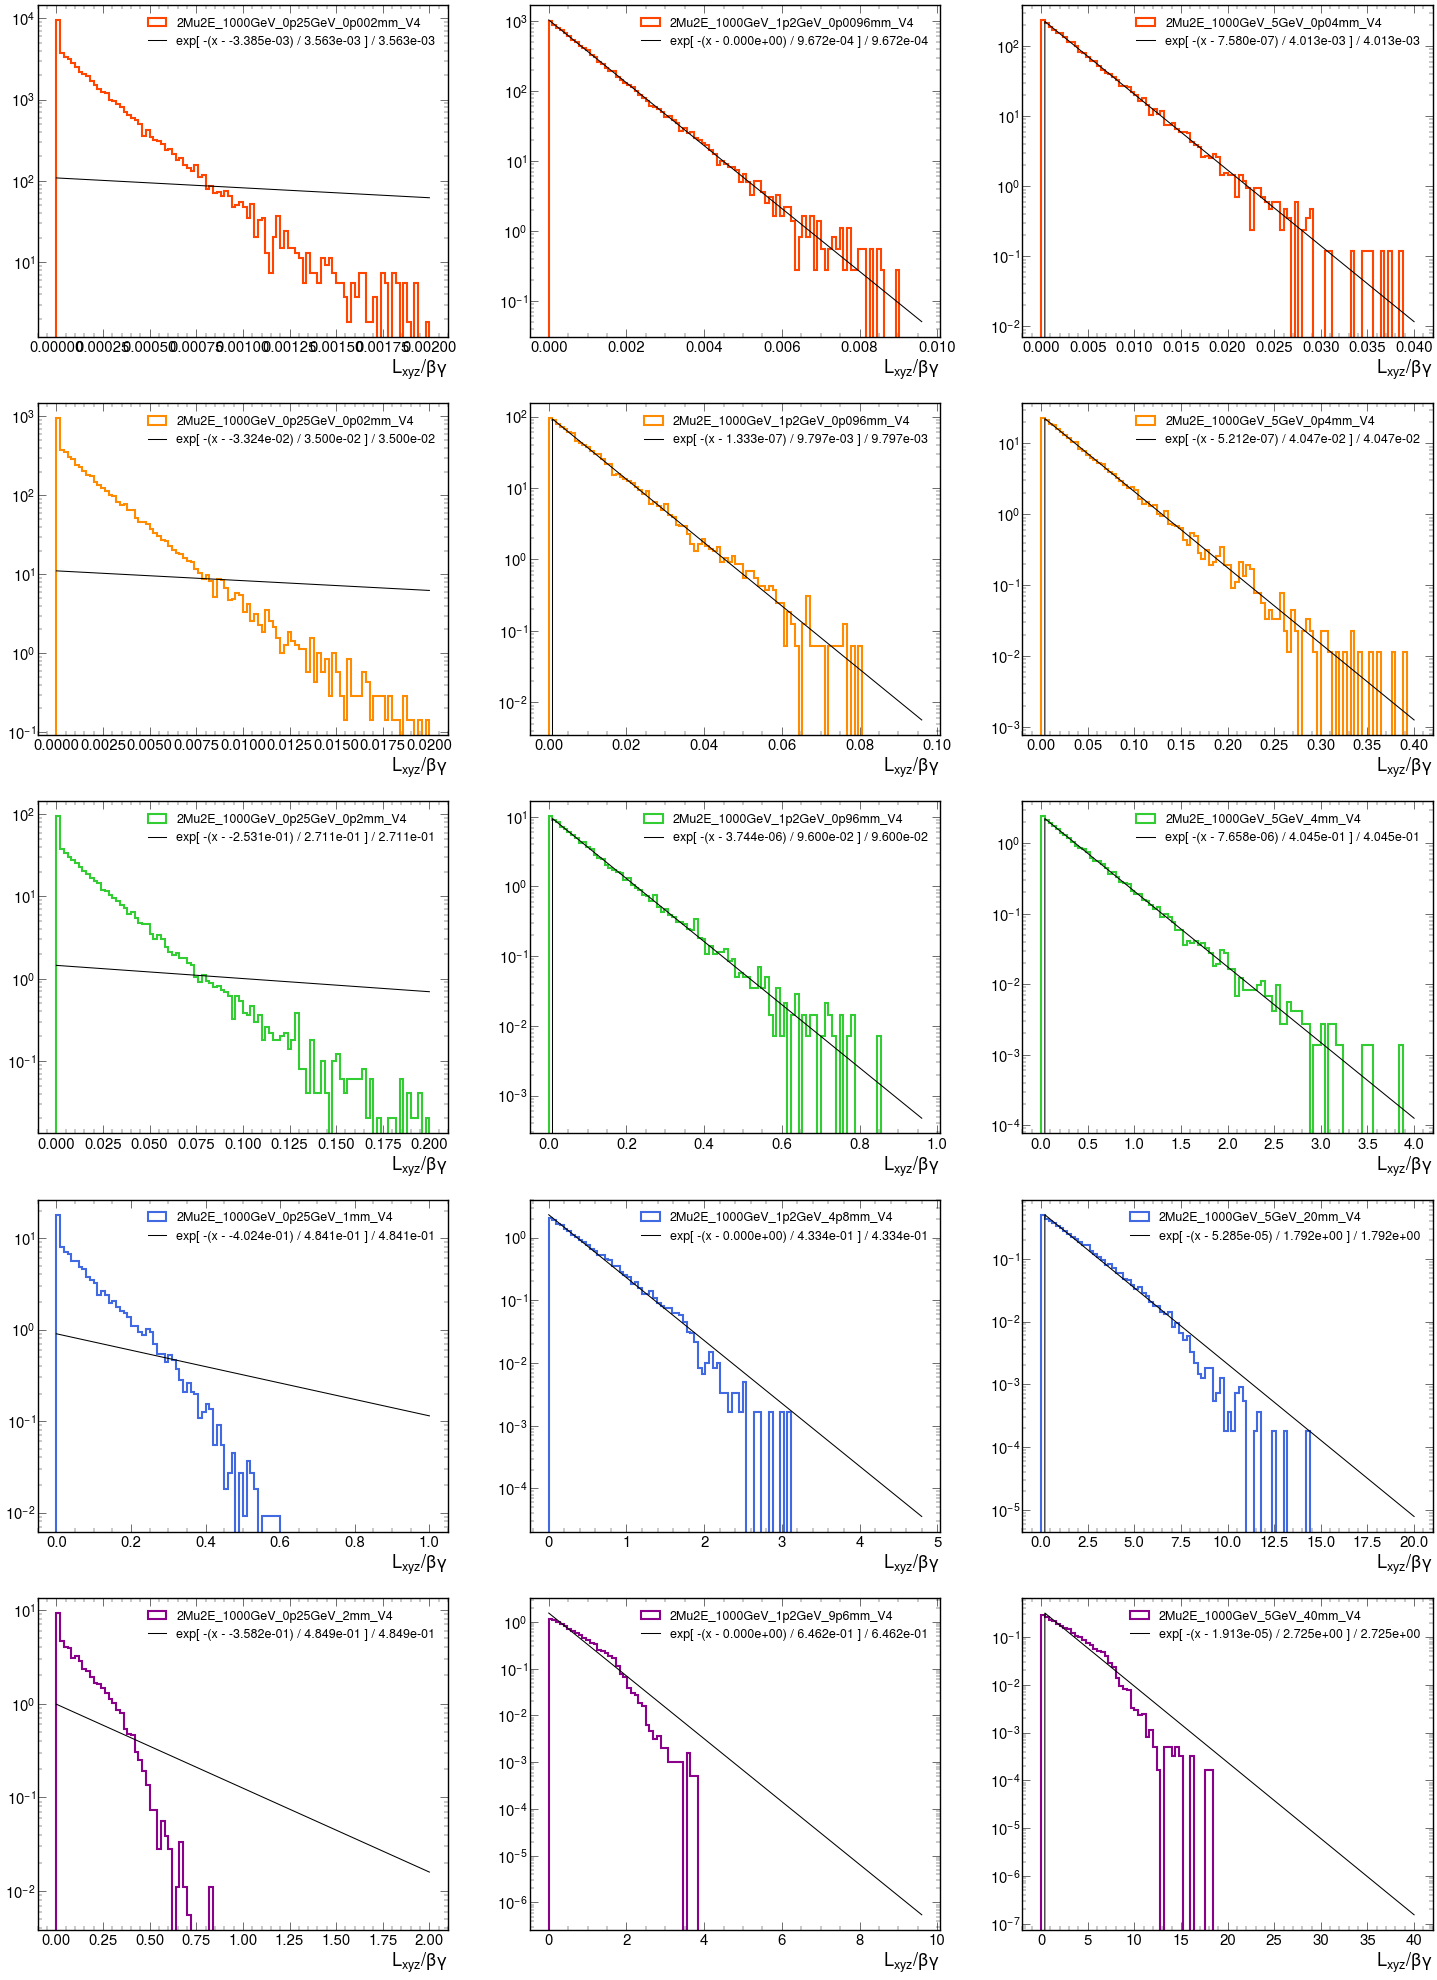

In [8]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(5, 3, figsize=(36, 50)) 

plotting_2mu2e(events_2mu, "2Mu2E_1000GeV_0p25GeV_0p002mm", 0.002,0,0, "orangered")
plotting_2mu2e(events_2mu, "2Mu2E_1000GeV_1p2GeV_0p0096mm", 0.0096,0,1, "orangered")
plotting_2mu2e(events_2mu, "2Mu2E_1000GeV_5GeV_0p04mm", 0.04,0,2, "orangered")

plotting_2mu2e(events_2mu, "2Mu2E_1000GeV_0p25GeV_0p02mm", 0.02,1,0, "darkorange")
plotting_2mu2e(events_2mu, "2Mu2E_1000GeV_1p2GeV_0p096mm", 0.096,1,1, "darkorange")
plotting_2mu2e(events_2mu, "2Mu2E_1000GeV_5GeV_0p4mm", 0.4,1,2, "darkorange")

plotting_2mu2e(events_2mu, "2Mu2E_1000GeV_0p25GeV_0p2mm", 0.2,2,0, "limegreen")
plotting_2mu2e(events_2mu, "2Mu2E_1000GeV_1p2GeV_0p96mm", 0.96,2,1, "limegreen")
plotting_2mu2e(events_2mu, "2Mu2E_1000GeV_5GeV_4mm", 4,2,2, "limegreen")

plotting_2mu2e(events_2mu, "2Mu2E_1000GeV_0p25GeV_1mm", 1,3,0, "royalblue")
plotting_2mu2e(events_2mu, "2Mu2E_1000GeV_1p2GeV_4p8mm", 4.8,3,1, "royalblue")
plotting_2mu2e(events_2mu, "2Mu2E_1000GeV_5GeV_20mm", 20,3,2, "royalblue")

plotting_2mu2e(events_2mu, "2Mu2E_1000GeV_0p25GeV_2mm", 2,4,0, "darkmagenta")
plotting_2mu2e(events_2mu, "2Mu2E_1000GeV_1p2GeV_9p6mm", 9.6,4,1, "darkmagenta")
plotting_2mu2e(events_2mu, "2Mu2E_1000GeV_5GeV_40mm", 40,4,2, "darkmagenta")